<a href="https://colab.research.google.com/github/PravyPrerana-1610/Codes/blob/main/EE_coin_position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

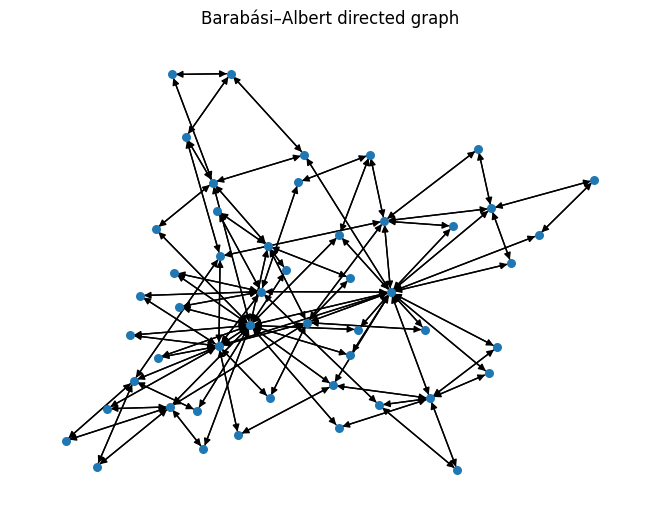

Quantum runs: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


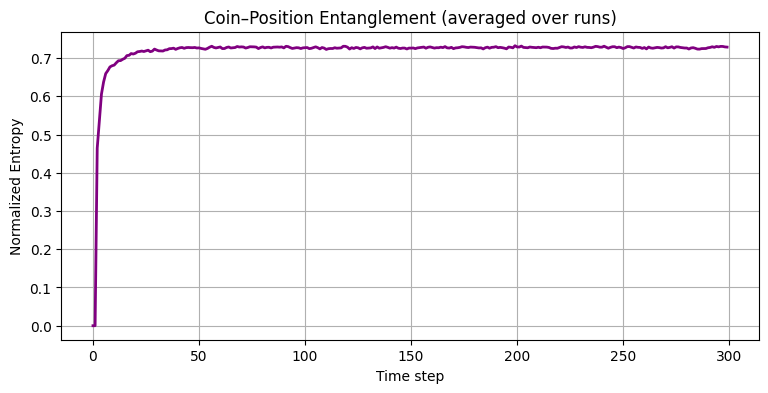

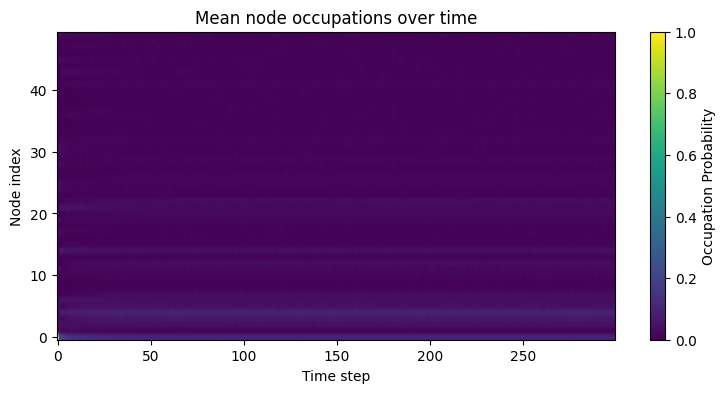

In [3]:

# === Quantum Run-and-Tumble on Barabási–Albert Graph with Coin–Position Entanglement ===
# Paste into Google Colab and run directly.

!pip install networkx tqdm joblib --quiet

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, svd
from joblib import Parallel, delayed
from tqdm import tqdm

# ==== Parameters ====
N_nodes = 50
m_links = 2
N_runs = 100
T = 300
p_tumble = 0.3
np.random.seed(42)

# ==== Graph ====
G = nx.barabasi_albert_graph(N_nodes, m_links).to_directed()
nx.draw(G, with_labels=False, node_size=30)
plt.title("Barabási–Albert directed graph")
plt.show()

# ==== Helper operators ====

def grover(d):
    """Grover coin for degree d."""
    return 2/d * np.ones((d, d)) - np.identity(d)

def FF(G1):
    """Flip–flop shift operator."""
    arcs = np.array(G1.edges)
    dim = len(arcs)
    flipflop = np.zeros((dim, dim))
    for idx, (u, v) in enumerate(arcs):
        # find reverse edge index
        rev = np.where((arcs == (v, u)).all(axis=1))[0]
        if len(rev) > 0:
            flipflop[rev[0], idx] = 1
        else:
            flipflop[idx, idx] = 1  # stay put if no reverse edge
    return flipflop

def grovercoin(G1):
    """Full Grover coin over all nodes."""
    out_deg = dict(G1.out_degree())
    coins = [grover(out_deg[node]) for node in G1.nodes]
    return block_diag(*coins)

def tumble(state, G1):
    """Randomly permute amplitudes on each node's outgoing edges."""
    degrees = np.array(G1.out_degree)
    out_deg_cumsum = np.cumsum(np.insert(degrees[:, 1], 0, 0))
    new_state = np.zeros_like(state)
    for node in G1.nodes:
        start, end = out_deg_cumsum[node], out_deg_cumsum[node+1]
        new_state[start:end] = np.random.permutation(state[start:end])
    return new_state

def node_occupations(state, degrees):
    """Occupation probability per node (sum over outgoing coin states)."""
    occ = np.empty(len(degrees), dtype=float)
    start = 0
    for i, deg in enumerate(degrees):
        node_slice = state[start:start+deg]
        occ[i] = np.sum(np.abs(node_slice)**2)
        start += deg
    return occ

def state_to_matrix(psi, G1):
    """Map state vector (edges) → node×node amplitude matrix."""
    dim = len(G1.nodes)
    edges = list(G1.edges)
    mat = np.zeros((dim, dim), dtype=complex)
    for j, val in enumerate(psi):
        u, v = edges[j]
        mat[u, v] = val
    return mat

def von_neumann_entropy(vals, tol=1e-12):
    """Von Neumann entropy from eigenvalues or Schmidt coefficients squared."""
    vals = vals[vals > tol]
    return -np.sum(vals * np.log2(vals))

# ==== Precompute ====
degrees = np.array([deg for _, deg in G.out_degree()])
dim = len(G.edges)
S = FF(G)
C = grovercoin(G)
U = S @ C

# ==== Initial state ====
init_state = np.zeros(dim, dtype=complex)
deg0 = G.out_degree(0)
init_state[:deg0] = 1 / np.sqrt(deg0)

# ==== Evolution with entanglement computation ====
def evolve_with_entanglement(init_state):
    state = init_state.copy()
    num_nodes = len(G.nodes)
    occupation = np.zeros((T, num_nodes))
    entanglement = np.zeros(T)

    for t in range(T):
        # record node occupations
        occupation[t] = node_occupations(state, degrees)

        # coin–position entanglement: Schmidt decomposition via SVD
        psi_matrix = state_to_matrix(state, G)
        _, svals, _ = svd(psi_matrix)
        svals = svals / np.linalg.norm(svals)  # normalize singular values
        entanglement[t] = von_neumann_entropy(svals**2) / np.log2(num_nodes)

        # evolve
        if np.random.rand() < p_tumble:
            state = tumble(state, G)
        else:
            state = U @ state

    return occupation, entanglement

# ==== Parallel Simulation ====
results = Parallel(n_jobs=-1)(
    delayed(evolve_with_entanglement)(init_state)
    for _ in tqdm(range(N_runs), desc='Quantum runs')
)

# Separate results
occupations = np.array([r[0] for r in results])
entropies = np.array([r[1] for r in results])

# ==== Average results ====
mean_ent = entropies.mean(axis=0)
mean_occ = occupations.mean(axis=0)

# ==== Plots ====
plt.figure(figsize=(9,4))
plt.plot(mean_ent, color='purple', lw=2)
plt.xlabel("Time step")
plt.ylabel("Normalized Entropy")
plt.title("Coin–Position Entanglement (averaged over runs)")
plt.grid(True)
plt.show()




/tmp/ipython-input-4258500255.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


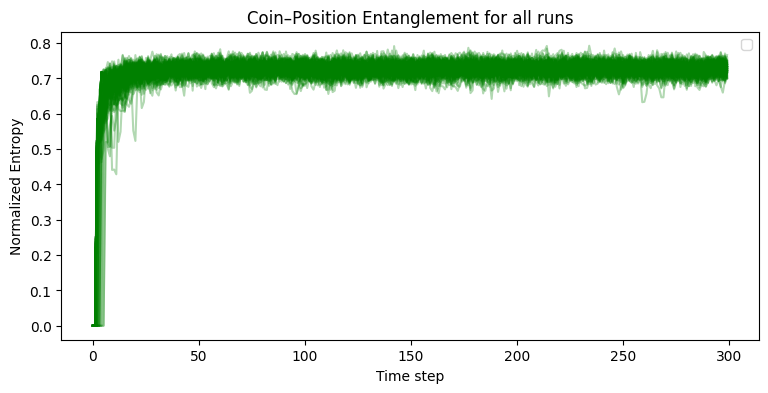

In [7]:
# ==== Plot entanglement for every run ====
plt.figure(figsize=(9,4))
for i in range(N_runs):
    plt.plot(entropies[i], color='green', alpha=0.3)
plt.xlabel("Time step")
plt.ylabel("Normalized Entropy")
plt.title("Coin–Position Entanglement for all runs")

plt.show()


# all coin permutations


<>:287: SyntaxWarning: invalid escape sequence '\l'
<>:287: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3560124512.py:287: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label=r'$S_{EE}/\log_2(N)$')


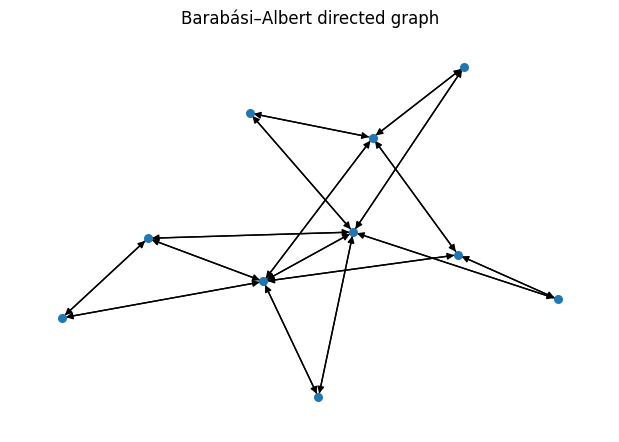

Max degree = 6, total permutations = 720
Factorial explosion detected (720 permutations). Sampling 200 permutations.
Testing 200 coin-permutation configurations (T = 100) ...


Coin permutations with tumbles: 100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


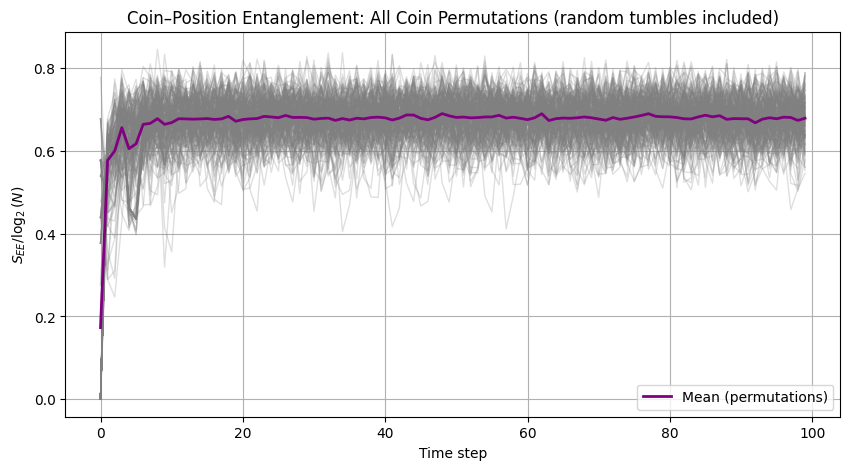

"\n# Optionally also show a heatmap of EE across permutations\nplt.figure(figsize=(10,6))\nplt.imshow(results_perm_tumble, aspect='auto', origin='lower')\nplt.colorbar(label=r'$S_{EE}/\\log_2(N)$')\nplt.xlabel('Time step')\nplt.ylabel('Permutation index')\nplt.title('Permutation-indexed entanglement trajectories')\nplt.show()\n\n# === done ==="

In [2]:
# === Quantum Run-and-Tumble on Barabási–Albert Graph
# Paste into Google Colab and run directly.

!pip install networkx tqdm joblib --quiet

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, svd
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import permutations
from numpy import linalg as LA
import math
import random

# -----------------------
# ==== Parameters =======
# -----------------------
N_nodes = 10
m_links = 2
N_runs = 10            # (kept for earlier part; not used for permutation sweep)
T = 100
p_tumble = 0.3
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# -----------------------
# ==== Graph ============
# -----------------------
G = nx.barabasi_albert_graph(N_nodes, m_links).to_directed()
plt.figure(figsize=(6,4))
nx.draw(G, with_labels=False, node_size=30)
plt.title("Barabási–Albert directed graph")
plt.show()

# -----------------------
# ==== Helper operators ==
# -----------------------
def grover(d):
    """Grover coin for degree d (d>=1)."""
    if d <= 0:
        return np.zeros((0,0))
    return 2/d * np.ones((d, d)) - np.eye(d)

def build_edges_and_indices(G1):
    """Return consistent edges list, out_indices lists, degrees array and dim."""
    edges = list(G1.edges())
    out_indices = [[] for _ in range(len(G1.nodes()))]
    for idx, (u, v) in enumerate(edges):
        out_indices[u].append(idx)
    degrees = np.array([d for _, d in G1.out_degree()])
    dim = len(edges)
    return edges, out_indices, degrees, dim

def FF(G1, edges):
    """Flip–flop shift mapping as an index array (vectorized)."""
    arcs = np.array(edges)  # shape (dim, 2)
    dim = len(arcs)
    flip_targets = np.arange(dim, dtype=int)
    for idx, (u, v) in enumerate(arcs):
        # find reverse edge index
        matches = np.where((arcs[:,0] == v) & (arcs[:,1] == u))[0]
        if matches.size > 0:
            flip_targets[idx] = matches[0]
        else:
            flip_targets[idx] = idx  # stay put if no reverse
    # produce the matrix S if needed: but we will use vectorized indexing
    return flip_targets

def grovercoin(G1, out_indices):
    """Full block-diagonal Grover coin (not used in permutation sweep but kept)."""
    coins = []
    for node_indices in out_indices:
        d = len(node_indices)
        if d > 0:
            coins.append(grover(d))
    if coins:
        return block_diag(*coins)
    else:
        return np.zeros((0,0))

def tumble(state, G1, out_indices):
    """Randomly permute amplitudes on each node's outgoing edges (in-place style return)."""
    new_state = np.zeros_like(state)
    for node, indices in enumerate(out_indices):
        if len(indices) == 0:
            continue
        new_state[indices] = np.random.permutation(state[indices])
    return new_state

def node_occupations(state, degrees, out_indices):
    """Occupation probability per node (sum over outgoing coin states)."""
    occ = np.empty(len(degrees), dtype=float)
    for i, indices in enumerate(out_indices):
        if len(indices) == 0:
            occ[i] = 0.0
        else:
            occ[i] = np.sum(np.abs(state[indices])**2)
    return occ

def state_to_matrix(psi, G1, edges):
    """Map state vector (edges) → node×node amplitude matrix using edges ordering."""
    dim_nodes = G1.number_of_nodes()
    mat = np.zeros((dim_nodes, dim_nodes), dtype=complex)
    for j, val in enumerate(psi):
        u, v = edges[j]
        mat[u, v] = val
    return mat

def von_neumann_entropy(vals, tol=1e-12):
    """Von Neumann entropy from eigenvalues or probabilities."""
    vals = np.array(vals)
    vals = vals[vals > tol]
    if vals.size == 0:
        return 0.0
    return -np.sum(vals * np.log2(vals))

# -----------------------
# ==== Precompute =======
# -----------------------
edges, out_indices, degrees, dim = build_edges_and_indices(G)
flip_targets = FF(G, edges)  # an index array such that new_state = old_state[flip_targets]
S_matrix = None  # we will use vectorized flip via indexing
C_matrix = grovercoin(G, out_indices)
# if needed: U = S @ C  (but in permutation sweep we apply permuted coin directly)
# U = S_matrix @ C_matrix

# -----------------------
# ==== Initial state =====
# -----------------------
init_state = np.zeros(dim, dtype=complex)
# initialize on outgoing arcs from node 0 (or choose whichever node you prefer)
deg0 = G.out_degree(0)
deg0 = int(deg0)
if deg0 > 0:
    for i, idx in enumerate(out_indices[0]):
        init_state[idx] = 1.0/np.sqrt(deg0)
else:
    # fallback: uniform on all edges
    init_state[:] = 1.0/np.sqrt(dim)

# -----------------------
# ==== Entanglement evolution (original single-run random tumble example) ====
# (kept here as reference; below we run permutation-sweep)
# -----------------------
def evolve_with_entanglement(init_state, T, p_tumble):
    state = init_state.copy()
    num_nodes = G.number_of_nodes()
    occupation = np.zeros((T, num_nodes))
    entanglement = np.zeros(T)
    for t in range(T):
        occupation[t] = node_occupations(state, degrees, out_indices)
        # compute entanglement
        psi_matrix = state_to_matrix(state, G, edges)
        _, svals, _ = svd(psi_matrix)
        if np.linalg.norm(svals) > 0:
            svals = svals / np.linalg.norm(svals)
            entanglement[t] = von_neumann_entropy(svals**2) / np.log2(num_nodes)
        else:
            entanglement[t] = 0.0
        # step
        if np.random.rand() < p_tumble:
            state = tumble(state, G, out_indices)
        else:
            # apply Grover coin then flip-flop via indices (vectorized)
            # build full coin by applying per-node grover then reassemble
            after_coin = np.zeros_like(state)
            for node, indices in enumerate(out_indices):
                if len(indices) == 0:
                    continue
                g = grover(len(indices))
                local = state[indices]
                after_coin[indices] = g @ local
            state = after_coin[flip_targets]
    return occupation, entanglement

# -----------------------
# ==== Permutation sweep ==
# -----------------------
def apply_permuted_coin(state, out_indices, perm_dict):
    """Apply node-wise Grover coin but with local basis permuted by perm_dict[node]."""
    new_state = np.zeros_like(state)
    for node, indices in enumerate(out_indices):
        d = len(indices)
        if d == 0:
            continue
        g = grover(d)
        # permute the basis if the perm dict gives a permutation for this node
        perm = perm_dict.get(node, np.arange(d))
        # ensure perm is array of correct length
        perm = np.array(perm, dtype=int)
        # reorder coin matrix basis: permute rows and columns
        g_perm = g[perm][:, perm]
        local = state[indices]
        new_state[indices] = g_perm @ local
    return new_state

def evolve_with_tumble_and_coin_perm(init_state, G1, edges, out_indices, flip_targets, perm_dict, t_max, p_tumble):
    """Single stochastic trajectory for a given coin-permutation configuration."""
    state = init_state.copy()
    n_nodes = G1.number_of_nodes()
    EE = np.zeros(t_max)
    for t in range(t_max):
        # Apply permuted coin
        after_coin = apply_permuted_coin(state, out_indices, perm_dict)
        # Apply flip-flop shift (vectorized)
        state = after_coin[flip_targets]
        # Random tumble
        if np.random.rand() < p_tumble:
            state = tumble(state, G1, out_indices)
        # Compute entanglement from node×node matrix
        mat = state_to_matrix(state, G1, edges)
        Svals = LA.svd(mat, compute_uv=False)
        if np.sum(Svals**2) > 0:
            s2 = (Svals**2) / np.sum(Svals**2)
            EE[t] = von_neumann_entropy(s2)
        else:
            EE[t] = 0.0
    return EE / np.log2(n_nodes)

# Build all permutations only for nodes with max degree
max_deg = int(np.max(degrees))
if max_deg <= 1:
    all_perms = [tuple(range(1))]  # trivial
else:
    all_perms = list(permutations(range(max_deg)))

n_perms = len(all_perms)
print(f"Max degree = {max_deg}, total permutations = {n_perms}")

# If factorial explosion, sample a subset for tractability
MAX_TO_TEST = 200   # change this if you want more or fewer
if n_perms > MAX_TO_TEST:
    print(f"Factorial explosion detected ({n_perms} permutations). Sampling {MAX_TO_TEST} permutations.")
    chosen_perm_indices = np.random.choice(n_perms, size=MAX_TO_TEST, replace=False)
    chosen_perms = [all_perms[i] for i in chosen_perm_indices]
else:
    chosen_perms = all_perms

# Build permutation dicts: for nodes with degree == max_deg apply permutation; else identity
perm_dicts = []
for perm in chosen_perms:
    pd = {}
    for node, indices in enumerate(out_indices):
        d = len(indices)
        if d == max_deg and max_deg > 0:
            # Use as many indices as deg; if deg == max_deg, perm provides mapping
            pd[node] = np.array(perm[:d], dtype=int)
        else:
            pd[node] = np.arange(d, dtype=int)
    perm_dicts.append(pd)

print(f"Testing {len(perm_dicts)} coin-permutation configurations (T = {T}) ...")

# Run in parallel: each permutation gets a single stochastic trajectory (random tumbles inside)
results_perm_tumble = Parallel(n_jobs=-1)(
    delayed(evolve_with_tumble_and_coin_perm)(
        init_state, G, edges, out_indices, flip_targets, perm_dict, T, p_tumble
    )
    for perm_dict in tqdm(perm_dicts, desc="Coin permutations with tumbles")
)

# Convert to array for plotting
results_perm_tumble = np.array(results_perm_tumble)  # shape (n_perm, T)

# -----------------------
# ==== Plot all curves ===
# -----------------------
plt.figure(figsize=(10,5))
for EE in results_perm_tumble:
    plt.plot(EE, color='gray', alpha=0.25, lw=1)
# overlay mean
mean_EE = results_perm_tumble.mean(axis=0)
plt.plot(mean_EE, color='purple', lw=2, label='Mean (permutations)')
plt.xlabel('Time step')
plt.ylabel(r'$S_{EE}/\log_2(N)$')
plt.title('Coin–Position Entanglement: All Coin Permutations (random tumbles included)')
plt.grid(True)
plt.legend()
plt.show()
'''
# Optionally also show a heatmap of EE across permutations
plt.figure(figsize=(10,6))
plt.imshow(results_perm_tumble, aspect='auto', origin='lower')
plt.colorbar(label=r'$S_{EE}/\log_2(N)$')
plt.xlabel('Time step')
plt.ylabel('Permutation index')
plt.title('Permutation-indexed entanglement trajectories')
plt.show()

# === done ==='''


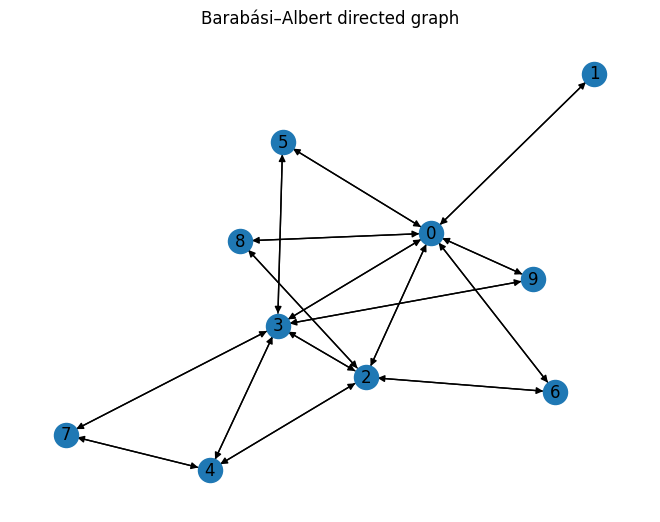

Coin permutations: 100%|██████████| 10/10 [00:00<00:00, 31.35it/s]


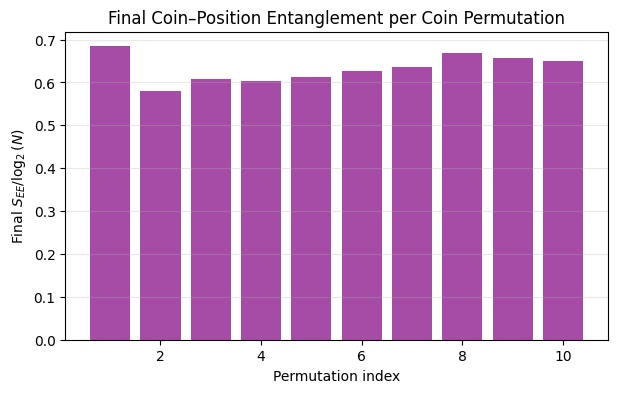

Permutation 1:  Final normalized EE = 0.6841
Permutation 2:  Final normalized EE = 0.5799
Permutation 3:  Final normalized EE = 0.6082
Permutation 4:  Final normalized EE = 0.6031
Permutation 5:  Final normalized EE = 0.6134
Permutation 6:  Final normalized EE = 0.6275
Permutation 7:  Final normalized EE = 0.6362
Permutation 8:  Final normalized EE = 0.6693
Permutation 9:  Final normalized EE = 0.6578
Permutation 10:  Final normalized EE = 0.6504


In [3]:
# === Quantum Run-and-Tumble on Barabási–Albert Graph (Final EE per Coin Permutation) ===
# Paste into Google Colab and run directly.

!pip install networkx tqdm joblib --quiet

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, svd
from tqdm import tqdm
from itertools import permutations
from joblib import Parallel, delayed
import random

# ==== Parameters ====
N_nodes = 10          # manageable size
m_links = 2
T = 200               # number of time steps
p_tumble = 0.3
N_permutations = 10   # number of random permutation configurations
np.random.seed(42)

# ==== Graph ====
G = nx.barabasi_albert_graph(N_nodes, m_links).to_directed()
nx.draw(G, node_size=300, with_labels=True)
plt.title("Barabási–Albert directed graph")
plt.show()

# ==== Helper functions ====
def grover(d):
    return 2/d * np.ones((d, d)) - np.eye(d)

def FF(G1):
    arcs = np.array(G1.edges)
    dim = len(arcs)
    S = np.zeros((dim, dim))
    for idx, (u, v) in enumerate(arcs):
        rev = np.where((arcs == (v, u)).all(axis=1))[0]
        S[rev[0], idx] = 1 if len(rev) > 0 else 0
    return S

def tumble_with_perm(state, out_indices, perm_dict):
    new_state = np.zeros_like(state)
    for node, idxs in enumerate(out_indices):
        perm = perm_dict[node]
        new_state[idxs] = state[idxs][perm]
    return new_state

def state_to_matrix(psi, G1):
    n = G1.number_of_nodes()
    M = np.zeros((n, n), dtype=complex)
    for (i, (u, v)) in enumerate(G1.edges):
        M[u, v] = psi[i]
    return M

def von_neumann_entropy(vals, tol=1e-12):
    vals = vals[vals > tol]
    return -np.sum(vals * np.log2(vals))

def grovercoin(G1):
    out_deg = dict(G1.out_degree())
    coins = [grover(out_deg[node]) for node in G1.nodes]
    return block_diag(*coins)

# ==== Precompute ====
degrees = np.array([deg for _, deg in G.out_degree()])
dim = len(G.edges)
S = FF(G)
C = grovercoin(G)
U = S @ C

# ==== Initial state ====
init_state = np.zeros(dim, dtype=complex)
deg0 = G.out_degree(0)
init_state[:deg0] = 1 / np.sqrt(deg0)

# ==== Outgoing edge indices ====
out_indices = []
offset = 0
for node in G.nodes:
    deg = G.out_degree(node)
    out_indices.append(np.arange(offset, offset + deg))
    offset += deg

# ==== Generate random coin permutations ====
max_deg = max(degrees)
base_perm = list(range(max_deg))
perm_samples = random.sample(list(permutations(base_perm)), k=N_permutations)

perm_dicts = []
for perm in perm_samples:
    perm_dict = {}
    for node, lst in enumerate(out_indices):
        if len(lst) == max_deg:
            perm_dict[node] = np.array(perm[:len(lst)])
        else:
            perm_dict[node] = np.random.permutation(len(lst))
    perm_dicts.append(perm_dict)

# ==== Evolution (record final EE only) ====
def evolve_final_EE(init_state, G1, out_indices, perm_dict, T):
    state = init_state.copy()
    n_nodes = G1.number_of_nodes()

    for t in range(T):
        if np.random.rand() < p_tumble:
            state = tumble_with_perm(state, out_indices, perm_dict)
        else:
            state = U @ state

    M = state_to_matrix(state, G1)
    _, svals, _ = svd(M)
    svals = svals / np.linalg.norm(svals)
    S_EE = von_neumann_entropy(svals**2) / np.log2(n_nodes)
    return S_EE

# ==== Parallel computation ====
final_EEs = Parallel(n_jobs=-1)(
    delayed(evolve_final_EE)(init_state, G, out_indices, perm_dict, T)
    for perm_dict in tqdm(perm_dicts, desc="Coin permutations")
)

# ==== Plot ====
plt.figure(figsize=(7,4))
plt.bar(range(1, N_permutations+1), final_EEs, color='purple', alpha=0.7)
plt.xlabel("Permutation index")
plt.ylabel(r'Final $S_{EE}/\log_2(N)$')
plt.title("Final Coin–Position Entanglement per Coin Permutation")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# ==== Print results ====
for i, val in enumerate(final_EEs, 1):
    print(f"Permutation {i}:  Final normalized EE = {val:.4f}")
